In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

In [2]:
# Verificar si TensorFlow detecta GPU
import tensorflow as tf
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Configurar para usar la GPU si está disponible
if tf.config.experimental.list_physical_devices('GPU'):
    # Limitar la cantidad de VRAM a utilizar si es necesario
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


In [4]:
# Cargar el dataset desde el archivo .pickle
archivo_pickle = 'affective_dataset.pkl'
with open(archivo_pickle, 'rb') as f:
    df_imagenes = pickle.load(f)


In [5]:
import pandas as pd
pd_pandas = pd.read_pickle('affective_dataset.pkl')
pd_pandas.head()

,image,face_landmarks,face_closeup,label
0,"[[[165, 165, 162], [165, 166, 161], [165, 166,...","[[[62, 83], [62, 88], [62, 92], [63, 97], [64,...","[[[[160 162 161], [160 162 161], [160 162 161]...",bored
1,"[[[164, 166, 161], [165, 167, 162], [164, 166,...","[[[62, 83], [62, 87], [63, 92], [63, 97], [64,...","[[[[160 162 160], [161 162 161], [160 161 160]...",bored
2,"[[[165, 165, 163], [165, 165, 163], [164, 165,...","[[[63, 82], [63, 87], [63, 91], [63, 96], [65,...","[[[[159 161 158], [160 162 159], [161 162 160]...",bored
3,"[[[165, 166, 162], [165, 165, 163], [165, 165,...","[[[63, 83], [63, 87], [63, 92], [63, 97], [64,...","[[[[159 161 158], [161 163 160], [155 157 154]...",bored
4,"[[[165, 166, 161], [166, 167, 162], [165, 167,...","[[[63, 82], [63, 87], [63, 91], [63, 96], [65,...","[[[[160 162 159], [161 163 161], [152 154 151]...",bored


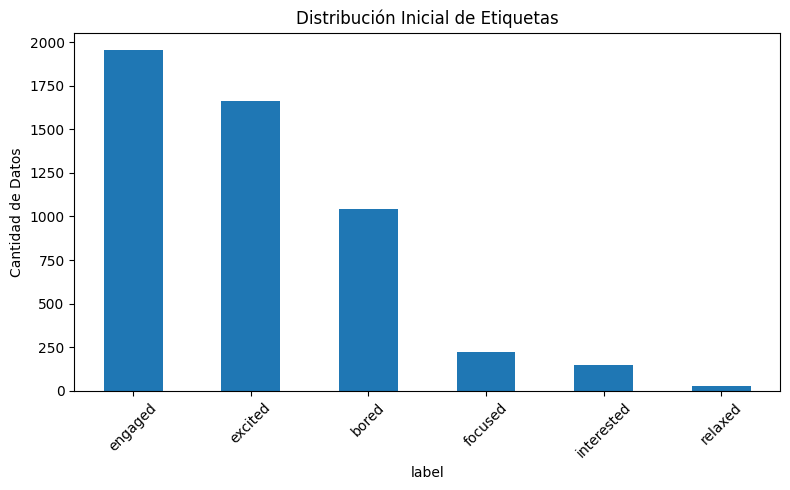

In [6]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df_imagenes['label'].value_counts().plot(kind='bar')
plt.xlabel('label')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Separar las características y etiquetas
X = np.array(df_imagenes['image'])
y = df_imagenes['label']


In [8]:
# Codificar las etiquetas
labels = y.unique()
y_encoded = pd.Categorical(y, categories=labels).codes

In [9]:
# Dividir el dataset en conjuntos de entrenamiento y validación
#X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2,stratify=y_encoded, random_state=42)


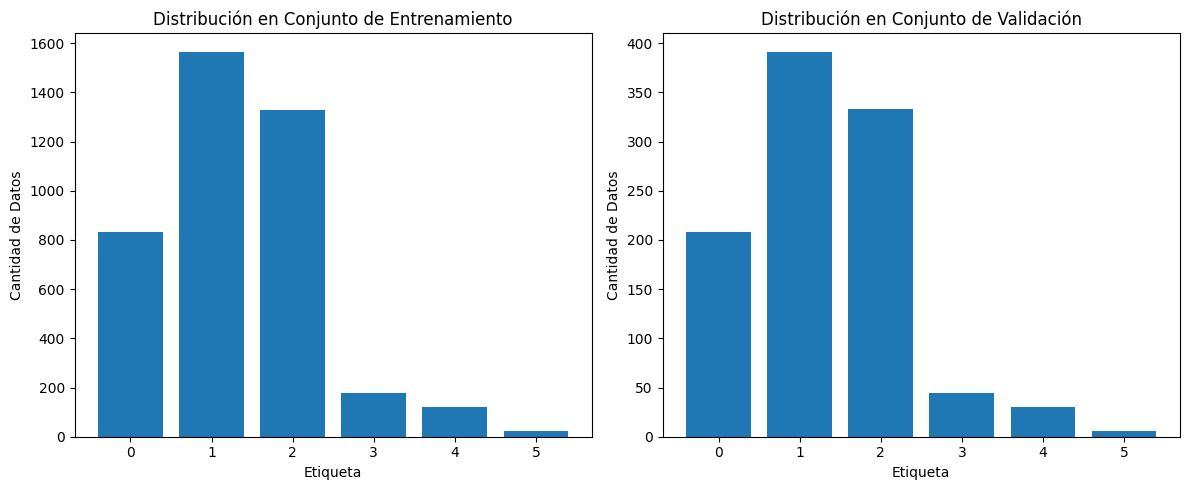

In [10]:
# Visualizar la distribución después de la división en entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(np.unique(y_train), np.bincount(y_train), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución en Conjunto de Entrenamiento')

plt.subplot(1, 2, 2)
plt.bar(np.unique(y_val), np.bincount(y_val), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución en Conjunto de Validación')

plt.tight_layout()
plt.show()

In [11]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

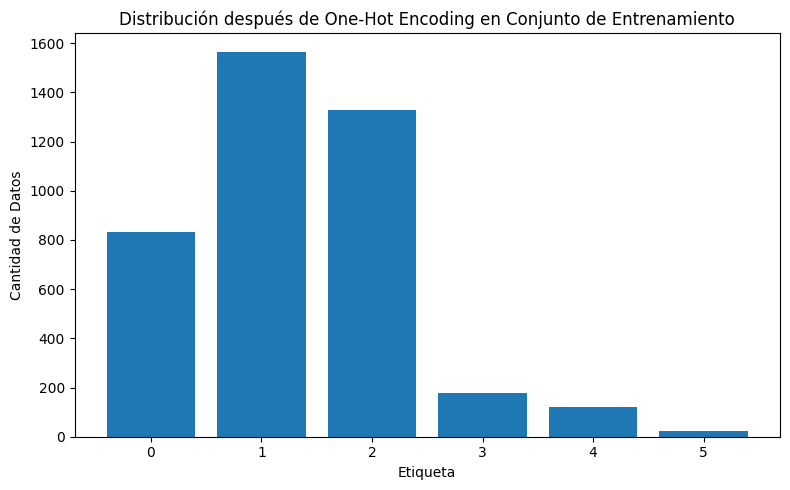

In [12]:
# Visualizar la distribución después de convertir las etiquetas a one-hot
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después de One-Hot Encoding en Conjunto de Entrenamiento')
plt.tight_layout()
plt.show()

In [13]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

In [14]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [15]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [16]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=32)


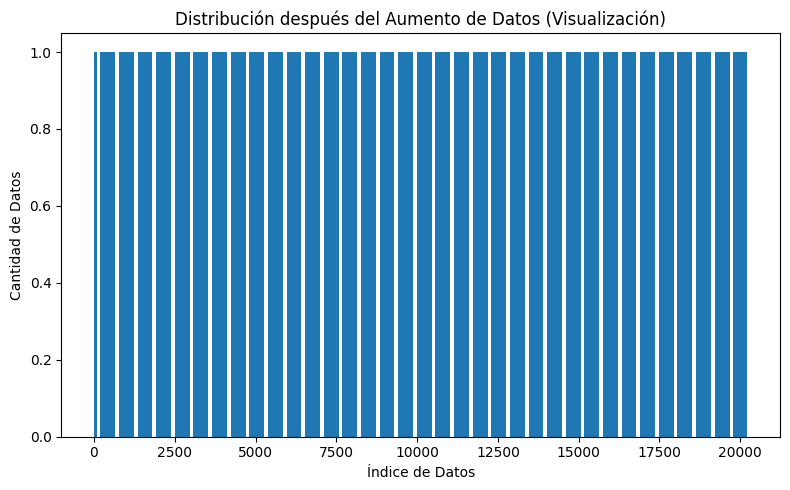

In [17]:
# Visualizar la distribución después del aumento de datos
num_aumento = 5  # Número de veces que se aplica el aumento de datos para la visualización
plt.figure(figsize=(8, 5))
plt.bar(range(len(X_train) * num_aumento), [1] * (len(X_train) * num_aumento), align='center')
plt.xlabel('Índice de Datos')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después del Aumento de Datos (Visualización)')
plt.tight_layout()
plt.show()


In [18]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(labels), activation='softmax')  # Capa de salida con activación softmax
])


In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.90:
            print('\nSe alcanzó una precisión de 90% en el entrenamiento. Se cancela el entrenamiento.')
            self.model.stop_training = True

back = myCallback()

In [20]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define el early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [21]:
# Entrenar el modelo con el callback de TensorBoard
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    callbacks=[early_stopping]
                    )


Epoch 1/100
127/127 [==============================] - 39s 241ms/step - loss: 1.2854 - accuracy: 0.4325 - val_loss: 1.0179 - val_accuracy: 0.6077
Epoch 2/100
127/127 [==============================] - 26s 208ms/step - loss: 0.9645 - accuracy: 0.5628 - val_loss: 0.8631 - val_accuracy: 0.6057
Epoch 3/100
127/127 [==============================] - 28s 219ms/step - loss: 0.9182 - accuracy: 0.5781 - val_loss: 0.9214 - val_accuracy: 0.6018
Epoch 4/100
127/127 [==============================] - 26s 208ms/step - loss: 0.8730 - accuracy: 0.6061 - val_loss: 0.8077 - val_accuracy: 0.6215
Epoch 5/100
127/127 [==============================] - 26s 207ms/step - loss: 0.8642 - accuracy: 0.6229 - val_loss: 0.8011 - val_accuracy: 0.6591
Epoch 6/100
127/127 [==============================] - 26s 203ms/step - loss: 0.8219 - accuracy: 0.6296 - val_loss: 0.7874 - val_accuracy: 0.6403
Epoch 7/100
127/127 [==============================] - 26s 205ms/step - loss: 0.8226 - accuracy: 0.6333 - val_loss: 0.7785 -

In [29]:
# Guardar el modelo
model.save('affective_CNN_trainned_stratified_672acc.h5')

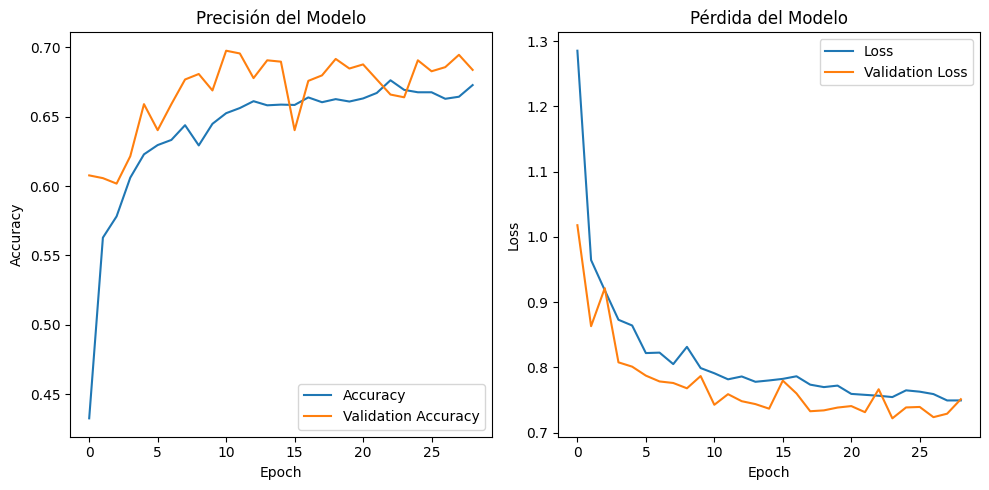

In [22]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

In [23]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 [==============================] - 1s 23ms/step


In [24]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)


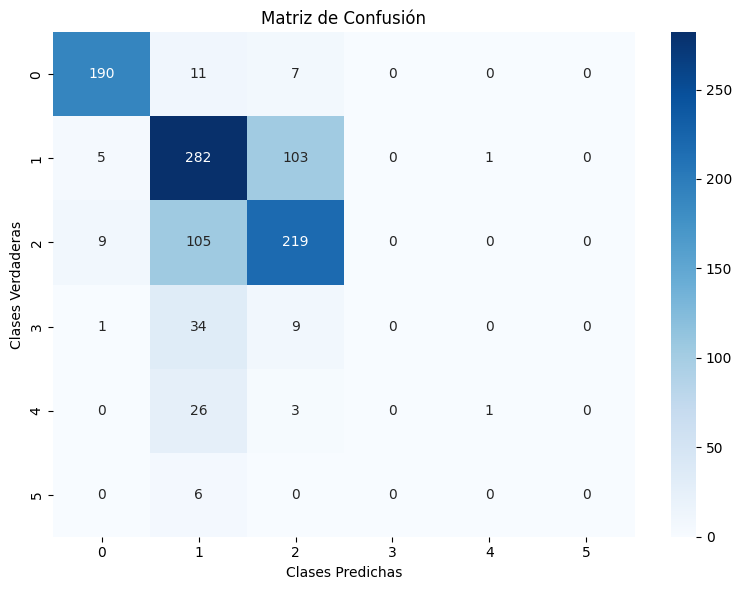

In [25]:
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

In [26]:
# Obtener las activaciones de las capas intermedias del modelo para una imagen de entrada
layer_outputs = [layer.output for layer in model.layers[1:]]  # Excluir la capa de entrada
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [27]:
# Obtener las activaciones para una imagen de entrada específica
sample_image = X_val[0].reshape(1, 150, 150, 3)  # Tomar la primera imagen del conjunto de validación como ejemplo
activations = activation_model.predict(sample_image)


1/1 [==============================] - 0s 284ms/step


ValueError: num must be an integer with 1 <= num <= 36, not 37

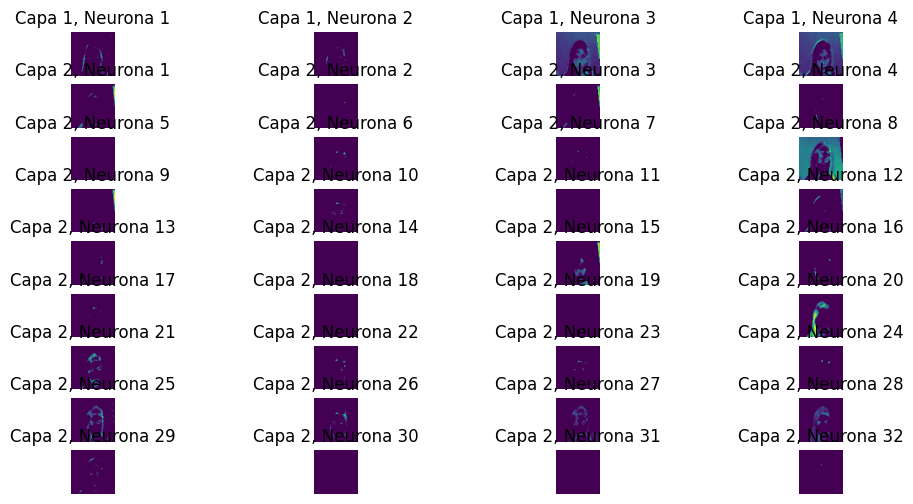

In [28]:
# Visualizar las activaciones como mapas de calor
plt.figure(figsize=(12, 6))
for i, activation_map in enumerate(activations):
    if len(activation_map.shape) == 4:  # Asegurarse de que sea un tensor 4D (por ejemplo, las activaciones de una capa Conv2D)
        for j in range(activation_map.shape[3]):
            plt.subplot(len(activations), 4, i * 4 + j + 1)
            plt.imshow(activation_map[0, :, :, j], cmap='viridis')
            plt.axis('off')
            plt.title(f'Capa {i+1}, Neurona {j+1}')
plt.tight_layout()
plt.show()